In [1]:
import requests
import pandas as pd
from rdkit import Chem
from concurrent.futures import ThreadPoolExecutor, as_completed
import time

from threading import Lock, Semaphore
from functools import wraps

In [2]:
import os
import psutil

def get_optimal_worker_count(io_bound=True):
    cpu_count = os.cpu_count()
    if cpu_count is None:
        return 4  # Default to 4 if we can't determine CPU count
    
    if io_bound:
        # For I/O bound tasks, we can use more workers
        return min(32, cpu_count * 4)
    else:
        # For CPU bound tasks, use number of CPU cores
        return cpu_count

# Usage
io_bound_workers = get_optimal_worker_count(io_bound=True)
cpu_bound_workers = get_optimal_worker_count(io_bound=False)

print(f"Recommended workers for I/O-bound tasks: {io_bound_workers}")
print(f"Recommended workers for CPU-bound tasks: {cpu_bound_workers}")

# Get more detailed system information
print(f"\nCPU cores: {psutil.cpu_count(logical=False)}")
print(f"Logical processors: {psutil.cpu_count(logical=True)}")
print(f"Total RAM: {psutil.virtual_memory().total / (1024**3):.2f} GB")

Recommended workers for I/O-bound tasks: 32
Recommended workers for CPU-bound tasks: 10

CPU cores: 10
Logical processors: 10
Total RAM: 32.00 GB


In [3]:
headers = [
  "Index", "Name", "Synonym", "Structure", "Mol. form.", "CAS Reg. No.", "Beilstein Reg. No.", "Mol. wt.",
  "Physical form", "tmp/ºC", "tbp/ºC", "Other bp/ºC", "ρ/g cm-3",
  "nD", "s/g kg-1", "vp/kPa (25 °C)", "Solubility"
]
headers = [h.strip() for h in headers]
headers, len(headers)

(['Index',
  'Name',
  'Synonym',
  'Structure',
  'Mol. form.',
  'CAS Reg. No.',
  'Beilstein Reg. No.',
  'Mol. wt.',
  'Physical form',
  'tmp/ºC',
  'tbp/ºC',
  'Other bp/ºC',
  'ρ/g cm-3',
  'nD',
  's/g kg-1',
  'vp/kPa (25 °C)',
  'Solubility'],
 17)

In [4]:
filename = 'physical_constants_of_organic_compounds_CRC_handbook_data_10902entries.csv'
df = pd.read_csv(filename, names=headers, skiprows=1, index_col='Index')
# remove structure column
df.drop(columns=['Structure'], inplace=True)
df

,Name,Synonym,Mol. form.,CAS Reg. No.,Beilstein Reg. No.,Mol. wt.,Physical form,tmp/ºC,tbp/ºC,Other bp/ºC,ρ/g cm-3,nD,s/g kg-1,vp/kPa (25 °C),Solubility
Index,,,,,,,,,,,,,,,
1,Abate,Temephos,C16H20O6P2S3,3383-96-8,NaN,466.469,cry,31.6(5),NaN,NaN,1.32,NaN,NaN,NaN,"sl H2O, hx; s ctc, eth, tol"
2,Abietic acid,Sylvic acid,C20H30O2,514-10-3,2221451.0,302.451,mcl pl (al-w),173.5,439.5,2509,1.0625,NaN,NaN,NaN,"vs ace, bz, eth, EtOH"
3,Abscisic acid,NaN,C15H20O4,21293-29-8,2698956.0,264.318,cry (chl-peth),160,120 subl,NaN,NaN,NaN,NaN,NaN,"vs ace, eth, chl"
4,Acacetin,"5,7-Dihydroxy-2-(4-methoxyphenyl)-4H-1-benzopy...",C16H12O5,480-44-4,277879.0,284.263,ye nd (95% al),263,NaN,NaN,NaN,NaN,NaN,NaN,vs EtOH
5,"Acebutolol, (±)-",NaN,C18H28N2O4,37517-30-9,NaN,336.426,cry,121,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
10898,Zinc gluconate,NaN,C12H22O14Zn,4468-02-4,NaN,455.704,pow,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
10899,"Zinc 2,4-pentanedioate",Zinc acetylacetonate,C10H14O4Zn,14024-63-6,4157976.0,263.625,cry,127.3(2),NaN,NaN,NaN,NaN,NaN,NaN,"sl H2O; s EtOH, DMSO"
10900,Zinc propanoate,NaN,C6H10O4Zn,557-28-8,NaN,211.550,hyg pl or nd,NaN,NaN,NaN,NaN,NaN,NaN,NaN,sl EtOH


In [5]:
class RateLimiter:
    def __init__(self, max_calls, period):
        self.semaphore = Semaphore(max_calls)
        self.period = period
        self.lock = Lock()
        self.last_reset = time.time()
        self.call_count = 0

    def __call__(self, func):
        @wraps(func)
        def wrapped(*args, **kwargs):
            with self.lock:
                current_time = time.time()
                if current_time - self.last_reset >= self.period:
                    self.call_count = 0
                    self.last_reset = current_time

            with self.semaphore:
                with self.lock:
                    self.call_count += 1
                    if self.call_count >= self.semaphore._value:
                        sleep_time = self.period - (current_time - self.last_reset)
                        if sleep_time > 0:
                            time.sleep(sleep_time)
                return func(*args, **kwargs)
        return wrapped


SMILES for CAS 3383-96-8: COP(=S)(OC)OC1=CC=C(C=C1)SC2=CC=C(C=C2)OP(=S)(OC)OC


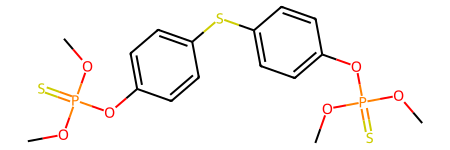

In [6]:
invalid_cas_numbers = []

# 5 requests per second is the maximum allowed by PubChem
@RateLimiter(max_calls=5, period=1)
def get_smiles_from_cas(cas_number):
    global invalid_cas_numbers
    # try:
    url = f"https://pubchem.ncbi.nlm.nih.gov/rest/pug/compound/name/{cas_number}/property/CanonicalSMILES/JSON"
    # time.sleep(0.5)
    response = requests.get(url)
    if response.status_code == 200:
        data = response.json()
        smiles = data['PropertyTable']['Properties'][0]['CanonicalSMILES']
        return smiles
    else:
        invalid_cas_numbers.append(cas_number)
        return None
    # except requests.RequestException:
    #     invalid_cas_numbers.append(cas_number)
    #     return None
    
cas_number = "3383-96-8"  # Example CAS number for water
smiles = get_smiles_from_cas(cas_number)
if smiles:
    print(f"SMILES for CAS {cas_number}: {smiles}")
    m = Chem.MolFromSmiles(smiles)
    display(m)
else:
    print(f"Could not retrieve SMILES for CAS {cas_number}")

In [36]:
# df.drop(columns=['SMILES'], inplace=True)
# df

,Name,Synonym,Mol. form.,CAS Reg. No.,Beilstein Reg. No.,Mol. wt.,Physical form,tmp/ºC,tbp/ºC,Other bp/ºC,ρ/g cm-3,nD,s/g kg-1,vp/kPa (25 °C),Solubility
Index,,,,,,,,,,,,,,,
1,Abate,Temephos,C16H20O6P2S3,3383-96-8,NaN,466.469,cry,31.6(5),NaN,NaN,1.32,NaN,NaN,NaN,"sl H2O, hx; s ctc, eth, tol"
2,Abietic acid,Sylvic acid,C20H30O2,514-10-3,2221451.0,302.451,mcl pl (al-w),173.5,439.5,2509,1.0625,NaN,NaN,NaN,"vs ace, bz, eth, EtOH"
3,Abscisic acid,NaN,C15H20O4,21293-29-8,2698956.0,264.318,cry (chl-peth),160,120 subl,NaN,NaN,NaN,NaN,NaN,"vs ace, eth, chl"
4,Acacetin,"5,7-Dihydroxy-2-(4-methoxyphenyl)-4H-1-benzopy...",C16H12O5,480-44-4,277879.0,284.263,ye nd (95% al),263,NaN,NaN,NaN,NaN,NaN,NaN,vs EtOH
5,"Acebutolol, (±)-",NaN,C18H28N2O4,37517-30-9,NaN,336.426,cry,121,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
10898,Zinc gluconate,NaN,C12H22O14Zn,4468-02-4,NaN,455.704,pow,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
10899,"Zinc 2,4-pentanedioate",Zinc acetylacetonate,C10H14O4Zn,14024-63-6,4157976.0,263.625,cry,127.3(2),NaN,NaN,NaN,NaN,NaN,NaN,"sl H2O; s EtOH, DMSO"
10900,Zinc propanoate,NaN,C6H10O4Zn,557-28-8,NaN,211.550,hyg pl or nd,NaN,NaN,NaN,NaN,NaN,NaN,NaN,sl EtOH


In [7]:
def process_cas_numbers(df, column_name, max_workers=5):
    with ThreadPoolExecutor(max_workers=max_workers) as executor:
        # Submit all tasks
        future_to_index = {executor.submit(get_smiles_from_cas, cas): index 
                           for index, cas in df[column_name].items()}
        
        # Process results as they complete
        results = {}
        for future in as_completed(future_to_index):
            index = future_to_index[future]
            try:
                result = future.result()
                results[index] = result
            except Exception as exc:
                print(f'CAS number at index {index} generated an exception: {exc}')
                results[index] = None
    
    return pd.Series(results)


In [8]:
df.iloc[:5]

,Name,Synonym,Mol. form.,CAS Reg. No.,Beilstein Reg. No.,Mol. wt.,Physical form,tmp/ºC,tbp/ºC,Other bp/ºC,ρ/g cm-3,nD,s/g kg-1,vp/kPa (25 °C),Solubility
Index,,,,,,,,,,,,,,,
1,Abate,Temephos,C16H20O6P2S3,3383-96-8,NaN,466.469,cry,31.6(5),NaN,NaN,1.32,NaN,NaN,NaN,"sl H2O, hx; s ctc, eth, tol"
2,Abietic acid,Sylvic acid,C20H30O2,514-10-3,2221451.0,302.451,mcl pl (al-w),173.5,439.5,2509,1.0625,NaN,NaN,NaN,"vs ace, bz, eth, EtOH"
3,Abscisic acid,NaN,C15H20O4,21293-29-8,2698956.0,264.318,cry (chl-peth),160,120 subl,NaN,NaN,NaN,NaN,NaN,"vs ace, eth, chl"
4,Acacetin,"5,7-Dihydroxy-2-(4-methoxyphenyl)-4H-1-benzopy...",C16H12O5,480-44-4,277879.0,284.263,ye nd (95% al),263,NaN,NaN,NaN,NaN,NaN,NaN,vs EtOH
5,"Acebutolol, (±)-",NaN,C18H28N2O4,37517-30-9,NaN,336.426,cry,121,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [11]:
# Process the DataFrame
start_time = time.time()
smiles = process_cas_numbers(df.iloc[:25], 'CAS Reg. No.')
end_time = time.time()

print(f"Processing time: {end_time - start_time:.2f} seconds")

Processing time: 16.31 seconds


In [14]:
smiles.isnull().sum(), smiles

(0,
 2             CC(C)C1=CC2=CCC3C(C2CC1)(CCCC3(C)C(=O)O)C
 1     COP(=S)(OC)OC1=CC=C(C=C1)SC2=CC=C(C=C2)OP(=S)(...
 3                CC1=CC(=O)CC(C1(C=CC(=CC(=O)O)C)O)(C)C
 5           CCCC(=O)NC1=CC(=C(C=C1)OCC(CNC(C)C)O)C(=O)C
 4           COC1=CC=C(C=C1)C2=CC(=O)C3=C(C=C(C=C3O2)O)O
 7                               C1CC2=CC=CC3=C2C1=CC=C3
 8                            C1=CC2=C3C(=C1)C=CC3=CC=C2
 10    CC(=O)CC(C1=CC=C(C=C1)[N+](=O)[O-])C2=C(C3=CC=...
 6     CC(=O)NC1=CC=C(C=C1)S(=O)(=O)C2=CC=C(C=C2)NC(=O)C
 9                     C1=CC2=C3C(=C1)C(=O)C(=O)C3=CC=C2
 11                                   CC(=O)NP(=O)(OC)SC
 14                                                 CC=O
 13                               CC1=CC(=O)NS(=O)(=O)O1
 12           CC(=O)C1=CC2=C(C=C1)SC3=CC=CC=C3N2CCCN(C)C
 17                                              CC(=O)N
 15                                     CC=NNC1=CC=CC=C1
 16                                                CC=NO
 19                        

In [46]:
smiles_old = df.iloc[:25]['CAS Reg. No.'].apply(get_smiles_from_cas)
smiles_old

Index
1     COP(=S)(OC)OC1=CC=C(C=C1)SC2=CC=C(C=C2)OP(=S)(...
2             CC(C)C1=CC2=CCC3C(C2CC1)(CCCC3(C)C(=O)O)C
3                CC1=CC(=O)CC(C1(C=CC(=CC(=O)O)C)O)(C)C
4           COC1=CC=C(C=C1)C2=CC(=O)C3=C(C=C(C=C3O2)O)O
5           CCCC(=O)NC1=CC(=C(C=C1)OCC(CNC(C)C)O)C(=O)C
6     CC(=O)NC1=CC=C(C=C1)S(=O)(=O)C2=CC=C(C=C2)NC(=O)C
7                               C1CC2=CC=CC3=C2C1=CC=C3
8                            C1=CC2=C3C(=C1)C=CC3=CC=C2
9                     C1=CC2=C3C(=C1)C(=O)C(=O)C3=CC=C2
10    CC(=O)CC(C1=CC=C(C=C1)[N+](=O)[O-])C2=C(C3=CC=...
11                                   CC(=O)NP(=O)(OC)SC
12           CC(=O)C1=CC2=C(C=C1)SC3=CC=CC=C3N2CCCN(C)C
13                               CC1=CC(=O)NS(=O)(=O)O1
14                                                 CC=O
15                                     CC=NNC1=CC=CC=C1
16                                                CC=NO
17                                              CC(=O)N
18                                   CC(=O

In [65]:
smiles_old.isnull().sum(), smiles_old[smiles_old.isnull()]

(1,
 Index
 48    None
 Name: CAS Reg. No., dtype: object)

In [63]:
df.iloc[48].isnull()

Name                  False
Synonym                True
Mol. form.            False
CAS Reg. No.          False
Beilstein Reg. No.    False
Mol. wt.              False
Physical form         False
tmp/ºC                False
tbp/ºC                 True
Other bp/ºC            True
ρ/g cm-3               True
nD                     True
s/g kg-1               True
vp/kPa (25 °C)         True
Solubility            False
Name: 49, dtype: bool

In [ ]:
df.to_csv(f"{filename}.smiles.csv")
df['SMILES']